### Vgg19 Classifier for ISIC 2019

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf

#helper modules
import numpy as np
import matplotlib.pyplot as plt
import os
import pathlib

In [2]:
tf.__version__

'2.2.0'

### Check that images is successfully downloaded

In [3]:
data_dir=pathlib.Path(".keras/datasets/isic_2019")
images_count=len(list(data_dir.glob("*/*/*.jpg")))

In [4]:
#images_count

## VGG19 for ISIC 2019

In [6]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

### Load the data

In [7]:
CLASS_NAMES=['Benign','Malignant','Unknown']
BATCH_SIZE = 32
STEPS_PER_EPOCH=images_count/BATCH_SIZE
IMG_HEIGHT = 224
IMG_WIDTH = 224
CHANNELS=3
IMG_SHAPE=(IMG_HEIGHT, IMG_WIDTH,CHANNELS)

In [8]:
def get_label(file_path):
    # convert the path to a list of path components
    parts = tf.strings.split(file_path, os.path.sep)
    if(parts[-3]=='test'):
      # The second to last is the class-directory
      return parts[-2] == CLASS_NAMES
    else:
        return parts[-2] == CLASS_NAMES[:2]

In [9]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, CHANNELS)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])

In [10]:
def process_path(file_path):
    label = get_label(file_path)
    # load the raw data from the file as a string
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [11]:
def prepare_batches(ds, cache=True, shuffle_buffer_size=1000):
    # This is a small dataset, only load it once, and keep it in memory.
    # use `.cache(filename)` to cache preprocessing work for datasets that don't
    # fit in memory.
    if cache:
        if isinstance(cache, str):
            ds = ds.cache(cache)
        else:
            ds = ds.cache()

    ds = ds.shuffle(buffer_size=shuffle_buffer_size)

    # Repeat forever
    ds = ds.repeat()

    ds = ds.batch(BATCH_SIZE)

    # `prefetch` lets the dataset fetch batches in the background while the model
    # is training.
    ds = ds.prefetch(buffer_size=AUTOTUNE)

    return ds

In [12]:
train_dir=pathlib.Path('.keras/datasets/isic_2019/train')
val_dir=pathlib.Path('.keras/datasets/isic_2019/validation')

In [13]:
train_ds = tf.data.Dataset.list_files(str(train_dir/'*/*'))
val_ds = tf.data.Dataset.list_files(str(val_dir/'*/*'))

In [14]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_labeled_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_labeled_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [15]:
for f in train_ds.take(5):
    print(f)

tf.Tensor(b'.keras/datasets/isic_2019/train/Benign/ISIC_0029732.jpg', shape=(), dtype=string)
tf.Tensor(b'.keras/datasets/isic_2019/train/Benign/ISIC_0032825.jpg', shape=(), dtype=string)
tf.Tensor(b'.keras/datasets/isic_2019/train/Malignant/ISIC_0057542.jpg', shape=(), dtype=string)
tf.Tensor(b'.keras/datasets/isic_2019/train/Benign/ISIC_0067550.jpg', shape=(), dtype=string)
tf.Tensor(b'.keras/datasets/isic_2019/train/Malignant/ISIC_0064875.jpg', shape=(), dtype=string)


In [16]:
for image, label in train_labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (224, 224, 3)
Label:  [ True False]


### Shuffle training data and get batches

In [17]:
train_ds = prepare_batches(train_labeled_ds)
val_ds=prepare_batches(val_labeled_ds)
image_batch, label_batch = next(iter(train_ds))

Understanding the data

In [21]:
def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(10):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        plt.title(CLASS_NAMES[np.where(label_batch[n])[0][0]])
        plt.axis('off')

In [19]:
image_batch.shape

TensorShape([32, 224, 224, 3])

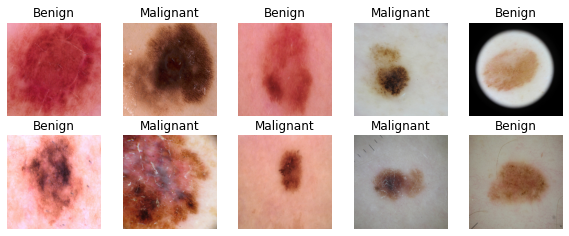

In [22]:
show_batch(image_batch.numpy(), label_batch.numpy())

### Download Vgg19 as base model

In [84]:
base_model=tf.keras.applications.VGG19(include_top=False, weights='imagenet', input_shape=IMG_SHAPE,classes=2)

In [85]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 512)


### Feature extraction

In [110]:
base_model.trainable = False

In [111]:
# Let's take a look at the base model architecture
#base_model.summary()

#### Add a classification head

In [112]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [113]:
dense_layer = tf.keras.layers.Dense(32, activation='relu')
dense_batch = dense_layer(feature_batch_average)
print(dense_batch.shape)

(32, 32)


In [114]:
prediction_layer = tf.keras.layers.Dense(2, activation='softmax')
prediction_batch = prediction_layer(dense_batch)
print(prediction_batch.shape)

(32, 2)


In [115]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  dense_layer,  
  prediction_layer
])

In [116]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [117]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_5 (Dense)              (None, 2)                 66        
Total params: 20,040,866
Trainable params: 16,482
Non-trainable params: 20,024,384
_________________________________________________________________


In [118]:
len(model.trainable_variables)

4

### Create callback for saving weights

In [119]:
# Include the epoch in the file name (uses `str.format`)
checkpoint_path = "vgg19_tune/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights every 5 epochs
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_feq=2)

### Train the model

In [120]:
validation_steps=images_count/BATCH_SIZE
initial_epoch=0
EPOCHS = 20

In [121]:
acc = []
val_acc = []

loss =[]
val_loss = []

In [40]:
loss0,accuracy0 = model.evaluate(val_ds, steps = validation_steps)

792/791 [==============================] - 92s 116ms/step - loss: 0.7479 - accuracy: 0.3937


In [41]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.39


In [156]:
history = model.fit(
    train_ds,
    initial_epoch=initial_epoch,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=validation_steps,
    steps_per_epoch=STEPS_PER_EPOCH, 
    callbacks=[cp_callback]
)

In [123]:
acc = acc + history.history['accuracy']
val_acc = val_acc + history.history['val_accuracy']

loss =loss + history.history['loss']
val_loss = val_loss + history.history['val_loss']

In [124]:
f=open("vgg19_train_acc.csv","w")
f.write('acc,val_acc,loss,val_loss\n')
f.close()

In [125]:
a=np.array([history.history['accuracy'],history.history['val_accuracy'],history.history['loss'],history.history['val_loss']]).T

In [126]:
#receives a list of strings
def write_csv(filename,recs):
    recs=recs.astype('str')
    print(recs.shape)
    f=open(filename,"a+")
    for rec in recs:
        f.write("%s\n" % ','.join(list(rec)))
    f.close()    

In [127]:
write_csv("vgg19_train_acc.csv",a)

(20, 4)


In [128]:
def read_csv(filename):
    f = open(filename,'r')
    recs = []
    lines = f.readlines()
    for line in lines:
        #print(line.strip('\n').split(','))
        recs.append(line.strip('\n').split(','))
    print(len(recs))
    return recs

In [52]:
# latest = tf.train.latest_checkpoint(checkpoint_dir) #choose the latest check point
# latest

# # # Load the previously saved weights
# model.load_weights(latest)

# # # Save the weights using the `checkpoint_path` format
# # model.save_weights(checkpoint_path.format(epoch=0))

### Fine Tuning

By unfreezing a small number of top layers

In [129]:
base_model.trainable = True

In [130]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

Number of layers in the base model:  22


In [131]:
# Fine-tune from this layer onwards
fine_tune_at = 16

In [132]:
# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [133]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              metrics=['accuracy'])

In [134]:
#model.summary()

In [135]:
len(model.trainable_variables)

12

In [137]:
history = model.fit(
    train_ds,
    initial_epoch=initial_epoch,
    epochs=EPOCHS,
    validation_data=val_ds,
    validation_steps=validation_steps,
    steps_per_epoch=STEPS_PER_EPOCH, 
    callbacks=[cp_callback]
)

### Visualize Learning curve

In [138]:
acc = acc + history.history['accuracy']
val_acc = val_acc + history.history['val_accuracy']

loss =loss + history.history['loss']
val_loss = val_loss + history.history['val_loss']


In [139]:
# f=open("vgg19_train_acc.csv","w")
# f.write('acc,val_acc,loss,val_loss\n')
# f.close()

In [140]:
a=np.array([history.history['accuracy'],history.history['val_accuracy'],history.history['loss'],history.history['val_loss']]).T
#a=a.astype('str')

In [141]:
#','.join(list(a[1]))

In [142]:
write_csv("vgg19_train_acc.csv",a)

(20, 4)


In [143]:
lr_curve=np.array(read_csv("vgg19_train_acc.csv"))

41


In [144]:
lr_curve.shape

(41, 4)

In [152]:
acc = lr_curve[1:,0].astype(float)
val_acc = lr_curve[1:,1].astype(float)
loss = lr_curve[1:,2].astype(float)
val_loss = lr_curve[1:,3].astype(float)

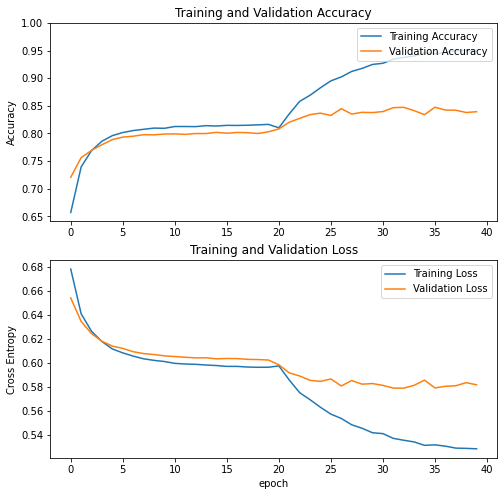

In [155]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
# plt.ylim([0.2,0.8])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### Save model

In [157]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('saved_model/my_model')

INFO:tensorflow:Assets written to: saved_model/my_model/assets


In [158]:
# my_model directory
!ls saved_model

# Contains an assets folder, saved_model.pb, and variables folder.
!ls saved_model/my_model

my_model
assets	saved_model.pb	variables


### Reload a keras model from a saved model

In [83]:
model = tf.keras.models.load_model('saved_model/my_model')

# # Check its architecture
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 7, 7, 512)         20024384  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                16416     
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 66        
Total params: 20,040,866
Trainable params: 20,040,866
Non-trainable params: 0
_________________________________________________________________
